## softmax从零开始实现 Iris

In [1]:
import torch
import torchvision
import numpy as np
import sys
sys.path.append("..") # 为了导入上层目录的d2lzh_pytorch  
import d2lzh_pytorch as d2l
import time

### 获取和读取数据

In [ ]:
def load_data(dir):
    """
    读入数据
    """
    with open(dir, 'r') as f:
        lines = f.readlines()
        lines = [line.strip('\n').split(',') for line in lines]
    xData = [line[1:] for line in lines]
    xData = np.array(xData)
    xData = xData.astype(float)
    yLabel = [line[0] for line in lines]
    yLabel = np.array(yLabel)
    yLabel = yLabel.astype(int)
    return xData, yLabel

In [ ]:
def random_split_data(xData, yLabel, rate=0.2, random_seed1=1):
    """
    随机分配训练集和测试集，并给予随机种子，方便复现
    一般数据训练集占80%，测试集占20%
    """
    X_train, X_test, y_train, y_test = train_test_split(xData, yLabel, test_size=rate, random_state=random_seed1)
    return X_train, y_train, X_test, y_test


In [3]:
num_inputs = 4
num_outputs = 3

W = torch.tensor(np.random.normal(0, 0.01, (num_inputs,num_outputs)), dtype=torch.float)
b = torch.zeros(num_outputs, dtype=torch.float)

In [4]:
W.requires_grad_(requires_grad=True) 
b.requires_grad_(requires_grad=True)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

### 定义模型

In [5]:
def softmax(X):
    X_exp = X.exp()
    partition = X_exp.sum(dim=1, keepdim=True)
    return X_exp / partition # 这⾥应⽤了广播机制

In [6]:
def net(X):
    return softmax(torch.mm(X.view(-1, num_inputs), W) + b)

In [7]:
def cross_entropy(y_hat, y):
    return - torch.log(y_hat.gather(1, y.view(-1, 1)))# 这里没有除以batch_size，是因为下面的sgd函数里面有一个除以batch_size的操作

In [8]:
def accuracy(y_hat, y):
    return (y_hat.argmax(dim=1) == y).float(0).mean().item()

In [9]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0 
    for X, y in data_iter:
        acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
        n += y.shape[0] 
    return acc_sum / n

In [10]:
print(evaluate_accuracy(test_iter, net))

0.1523


In [21]:
num_epochs, lr = 5, 0.1
# 本函数已保存在d2lzh包中方便以后使用
def train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size,
params=None, lr=None, optimizer=None):
    start_total = time.time()
    for epoch in range(num_epochs): 
        start = time.time()
        train_l_sum, train_acc_sum, n = 0.0,0.0,0
        for X, y in train_iter: 
            y_hat = net(X)
            l = loss(y_hat, y).sum() 
            
            # 梯度清零
            if optimizer is not None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params: 
                    param.grad.data.zero_()
                    
            l.backward()
            if optimizer is None:
                d2l.sgd(params, lr, batch_size)
            else:
                optimizer.step() # “softmax回归的简洁实现”⼀一节将⽤用到
                
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
            n += y.shape[0]
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, %.2f sec'
       % (epoch + 1, train_l_sum / n, train_acc_sum / n,test_acc, (time.time() - start)))
    print('total time %.2f sec' % (time.time() - start_total))

In [22]:
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, batch_size, [W, b], lr)

epoch 1, loss 0.7273, train acc 0.766, test acc 0.793, 1.88 sec
epoch 2, loss 0.5682, train acc 0.814, test acc 0.810, 1.93 sec
epoch 3, loss 0.5244, train acc 0.825, test acc 0.821, 1.99 sec
epoch 4, loss 0.4999, train acc 0.832, test acc 0.825, 2.33 sec
epoch 5, loss 0.4854, train acc 0.836, test acc 0.823, 2.13 sec
total time 10.26 sec


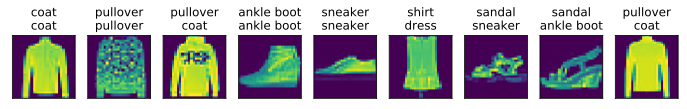

In [13]:
X, y = iter(test_iter).next() 
true_labels = d2l.get_fashion_mnist_labels(y.numpy())
pred_labels = \
d2l.get_fashion_mnist_labels(net(X).argmax(dim=1).numpy())
titles = [true + '\n' + pred for true, pred in zip(true_labels,
pred_labels)]
d2l.show_fashion_mnist(X[247:256], titles[247:256])

In [14]:
x = X.view(X.shape[0], -1) #  不管多少列，我只要X.shape[0]行，由于有265个样本，所以自动将1*28*28拉伸为一列，所以得到256*784

In [15]:
x.shape

torch.Size([256, 784])

In [16]:
X.shape

torch.Size([256, 1, 28, 28])